# Online Joint State and Parameters Estimation for HAR SSM
State space model
\begin{align*}
    &\Theta_{t}^{(1)} = A(\Theta^{(2)})\Theta_{t-1}^{(1)} + \mathbf{p}_{t_{\theta}} \quad \mathbf{p}_{t_{\theta}} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_\theta^{-1}) \\
    &\mathbf{x}_t = A(\Theta_{t}^{(1)})\mathbf{x}_{t-1} + \mathbf{p}_{t_{x}} \quad \mathbf{p}_{t_{x}} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_x^{-1}) \\
    &y_t = \mathbf{c}^\text{T}\mathbf{x}_t + m_t \quad v_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

where
\begin{align*}
    &\Theta^{(1)}_t = (\theta_t, \theta_{t-1}, \dots, \theta_{t-p+1})^\text{T} \quad \Theta^{(1)}_{t-1} = (\theta_{t-1}, \theta_{t-2}, \dots, \theta_{t-p})^\text{T} \\
    &\mathbf{x}_t = (x_t, x_{t-1}, \dots, x_{t-p+1})^\text{T} \quad \mathbf{x}_{t-1} = (x_{t-1}, x_{t-2}, \dots, x_{t-p})^\text{T} 
    \\ \\
    &A(\Theta) = 
    \begin{bmatrix}
         \Theta^{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \quad
    \mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
\end{align*}

Note: we clamp $\gamma_y = \frac{1}{200}$ (high variance)

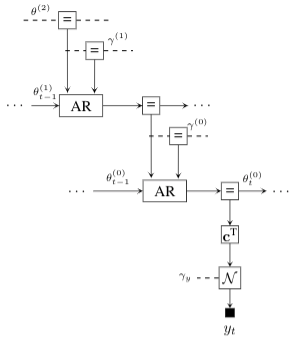

In [2]:
using Images
img = load("../ffgs/HAR-online.png")

In [1]:
using ProgressMeter
using Revise
using ForneyLab
using Random
using Plots
using LaTeXStrings
using StatsPlots
include("../data/DataAR.jl")
include("../ARNode/ARNode.jl")
include("../helpers/functions.jl")
using .ARNode, .DataAR
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision
diagAR(dim) = Matrix{Float64}(I, dim, dim)

diagAR (generic function with 1 method)

In [2]:
Random.seed!(42)

HARorder = 1

v_Œ∏1 = 0.5
v_x = 1.0

dataHAR = generateHAR(1000, HARorder, levels=2, nvars=[v_Œ∏1, v_x], stat=true)
coefs = dataHAR[1]
Œ∏ = [Œ∏[1] for Œ∏ in dataHAR[2]]
x = [x[1] for x in dataHAR[3]]

# Observations
v_y = 10.0
y = [xi[1] + sqrt(v_y)*randn() for xi in dataHAR[3]];

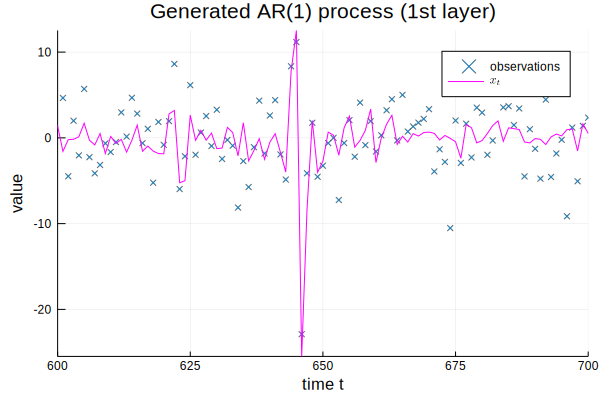

In [3]:
# Plotting the data
from = 600; upto = 700;
plot(xlims=(from, upto), ylims=(minimum(x[from:upto]), maximum(x[from:upto])))
scatter!(y, markershape = :xcross, markeralpha = 0.6,
        markersize = 2, xlabel="time t", ylabel="value", label="observations")
plot!(x, color=:magenta, label=L"x_t", title="Generated AR($HARorder) process (1st layer)")

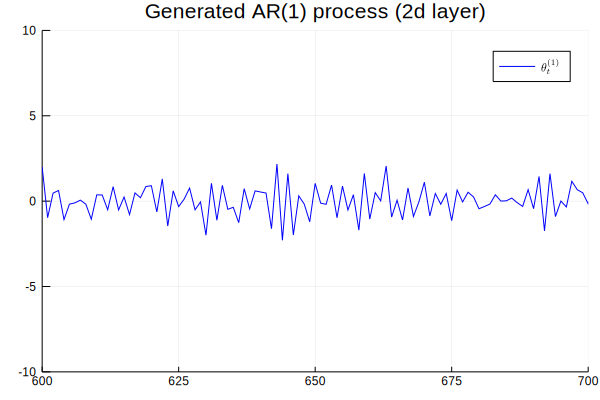

In [4]:
plot(xlims=(from, upto), ylims=(-10, 10))
plot!(Œ∏, color=:blue, label=L"\theta_t^{(1)}", title="Generated AR($HARorder) process (2d layer)")

In [5]:
# Creating the graph
g = FactorGraph()

# Upper layer
@RV m_Œ∏2
@RV w_Œ∏2
@RV Œ∏2 ~ GaussianMeanPrecision(m_Œ∏2, w_Œ∏2)
@RV a_Œ∏1
@RV b_Œ∏1
@RV w_Œ∏1 ~ Gamma(a_Œ∏1, b_Œ∏1)
@RV m_Œ∏1_t_prev
@RV w_Œ∏1_t_prev
@RV Œ∏1_t_prev ~ GaussianMeanPrecision(m_Œ∏1_t_prev, w_Œ∏1_t_prev)
@RV Œ∏1_t ~ Autoregression(Œ∏2, Œ∏1_t_prev, w_Œ∏1)

# Second layer
@RV a_x
@RV b_x
@RV w_x ~ Gamma(a_x, b_x)
@RV m_x_t_prev
@RV w_x_t_prev
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV x_t ~ Autoregression(Œ∏1_t, x_t_prev, w_x)

# Observation
c = zeros(HARorder); c[1] = 1;
@RV y_t ~ GaussianMeanPrecision(dot(c, x_t), placeholder(:w_y_t))

# Placeholders for prior of upper layer
placeholder(m_Œ∏2, :m_Œ∏2, dims=(HARorder,))
placeholder(w_Œ∏2, :w_Œ∏2, dims=(HARorder, HARorder))
placeholder(a_Œ∏1, :a_Œ∏1)
placeholder(b_Œ∏1, :b_Œ∏1)
placeholder(m_Œ∏1_t_prev, :m_Œ∏1_t_prev, dims=(HARorder,))
placeholder(w_Œ∏1_t_prev, :w_Œ∏1_t_prev, dims=(HARorder, HARorder))

# Placeholders for prior of bottom layer
placeholder(a_x, :a_x)
placeholder(b_x, :b_x)
placeholder(m_x_t_prev, :m_x_t_prev, dims=(HARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(HARorder, HARorder))

# Placeholder for data
placeholder(y_t, :y_t)

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 11442092230870929531 -->
 
 11442092230870929531 
 
 ùí© 
 gaussianmeanprecision_2 
 
<!-- 18216746812272671751 -->
 
 18216746812272671751 
 
 placeholder_y_t 
 
<!-- 16279983721144031974 -->
 
 16279983721144031974 
 
 ùí© 
 gaussianmeanprecision_4 
 
<!-- 18216746812272671751--16279983721144031974 -->
 
 18216746812272671751--16279983721144031974 
 
 y_t 
 1 out 
 1 out 
 
<!-- 12035885424845010974 -->
 
 12035885424845010974 
 
 placeholder_w_x_t_prev 
 
<!-- 15188919985884841430 -->
 
 15188919985884841430 
 
 ùí© 
 gaussianmeanprecision_3 
 
<!-- 12035885424845010974--15188919985884841430 -->
 
 12035885424845010974--15188919985884841430 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 12701096378651157091 -->
 
 12701096378651157091 
 
 AR 
 autoregression_1 
 
<!-- 12701096378651157091--11442092230870929531 -->
 
 12701096378651157091--11442092230870929531 
 
 Œ∏1_t_prev 
 1 out 
 2 x 
 
<!-- 3897317892967831850 -->
 
 3897317892967831850 
 
 Gam 
 gamma_1 
 
<!-- 12701096378651157091--3897317892967831850 -->
 
 12701096378651157091--3897317892967831850 
 
 w_Œ∏1 
 1 out 
 4 Œ≥ 
 
<!-- 8700861447416690289 -->
 
 8700861447416690289 
 
 ùí© 
 gaussianmeanprecision_1 
 
<!-- 12701096378651157091--8700861447416690289 -->
 
 12701096378651157091--8700861447416690289 
 
 Œ∏2 
 1 out 
 3 Œ∏ 
 
<!-- 18353031304472187323 -->
 
 18353031304472187323 
 
 placeholder_w_y_t 
 
<!-- 16279983721144031974--18353031304472187323 -->
 
 16279983721144031974--18353031304472187323 
 
 w_y_t 
 1 out 
 3 w 
 
<!-- 13066796616101049551 -->
 
 13066796616101049551 
 
 dot 
 dotproduct_1 
 
<!-- 16279983721144031974--13066796616101049551 -->
 
 16279983721144031974--13066796616101049551 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 4554199195859790499 -->
 
 4554199195859790499 
 
 placeholder_b_x 
 
<!-- 7850846204087377920 -->
 
 7850846204087377920 
 
 Gam 
 gamma_2 
 
<!-- 4554199195859790499--7850846204087377920 -->
 
 4554199195859790499--7850846204087377920 
 
 b_x 
 3 b 
 1 out 
 
<!-- 9679740972974629292 -->
 
 9679740972974629292 
 
 clamp_1 
 
<!-- 15360391345462087684 -->
 
 15360391345462087684 
 
 AR 
 autoregression_2 
 
<!-- 15360391345462087684--12701096378651157091 -->
 
 15360391345462087684--12701096378651157091 
 
 Œ∏1_t 
 1 y 
 3 Œ∏ 
 
<!-- 15360391345462087684--7850846204087377920 -->
 
 15360391345462087684--7850846204087377920 
 
 w_x 
 1 out 
 4 Œ≥ 
 
<!-- 15360391345462087684--15188919985884841430 -->
 
 15360391345462087684--15188919985884841430 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 9379774892817707441 -->
 
 9379774892817707441 
 
 placeholder_a_Œ∏1 
 
<!-- 9379774892817707441--3897317892967831850 -->
 
 9379774892817707441--3897317892967831850 
 
 a_Œ∏1 
 2 a 
 1 out 
 
<!-- 176491839649854657 -->
 
 176491839649854657 
 
 placeholder_b_Œ∏1 
 
<!-- 176491839649854657--3897317892967831850 -->
 
 176491839649854657--3897317892967831850 
 
 b_Œ∏1 
 3 b 
 1 out 
 
<!-- 9946489597938757500 -->
 
 9946489597938757500 
 
 placeholder_m_Œ∏1_t_prev 
 
<!-- 9946489597938757500--11442092230870929531 -->
 
 9946489597938757500--11442092230870929531 
 
 m_Œ∏1_t_prev 
 2 m 
 1 out 
 
<!-- 11006211506726873336 -->
 
 11006211506726873336 
 
 placeholder_w_Œ∏2 
 
<!-- 11006211506726873336--8700861447416690289 -->
 
 11006211506726873336--8700861447416690289 
 
 w_Œ∏2 
 3 w 
 1 out 
 
<!-- 11030378353547258909 -->
 
 11030378353547258909 
 
 placeholder_a_x 
 
<!-- 11030378353547258909--7850846204087377920 -->
 
 11030378353547258909--7850846204087377920 
 
 a_x 
 2 a 
 1 out 
 
<!-- 7143129155051681556 -->
 
 7143129155051681556 
 
 placeholder_m_Œ∏2 
 
<!-- 7143129155051681556--8700861447416690289 -->
 
 7143129155051681556--8700861447416690289 
 
 m_Œ∏2 
 2 m 
 1 out 
 
<!-- 13066796616101049

In [6]:
# Specify recognition factorization
q = RecognitionFactorization(Œ∏1_t, Œ∏2, Œ∏1_t_prev, w_Œ∏1, x_t, x_t_prev, w_x,
                             ids=[:Œ∏1_t :Œ∏2 :Œ∏1_t_prev :W_Œ∏1 :X_t :X_t_prev :W_x])

algo = variationalAlgorithm(q)
algoF = freeEnergyAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algoF))

freeEnergy (generic function with 1 method)

In [15]:
# Storage for upper layer
m_Œ∏1 = Vector{Vector{Float64}}(undef, length(y))
w_Œ∏1 = Vector{Array{Float64, 2}}(undef, length(y))
m_Œ∏1_prev = Vector{Vector{Float64}}(undef, length(y))
w_Œ∏1_prev = Vector{Array{Float64, 2}}(undef, length(y))
m_Œ∏2 = Vector{Vector{Float64}}(undef, length(y))
w_Œ∏2 = Vector{Array{Float64, 2}}(undef, length(y))
a_Œ∏1 = Vector{Float64}(undef, length(y))
b_Œ∏1 = Vector{Float64}(undef, length(y))

# Storage for bottom layer
m_x = Vector{Vector{Float64}}(undef, length(y))
w_x = Vector{Array{Float64, 2}}(undef, length(y))
a_x = Vector{Float64}(undef, length(y))
b_x = Vector{Float64}(undef, length(y))

# Define values for upper layer
m_Œ∏2_0 = ones(HARorder)
w_Œ∏2_0 = diagAR(HARorder)
a_Œ∏1_0 = 0.00001
b_Œ∏1_0 = 0.00001
m_Œ∏1_prev_0 = ones(HARorder)
w_Œ∏1_prev_0 = diagAR(HARorder)
m_Œ∏1_t_0 = ones(HARorder)
w_Œ∏1_t_0 = diagAR(HARorder)

# Define values for bottom layer
a_x_0 = 0.00001
b_x_0 = 1.0
m_x_t_prev_0 = zeros(HARorder)
w_x_t_prev_0 = huge*diagAR(HARorder)

# Priors upper layer
m_Œ∏2_min = m_Œ∏2_0
w_Œ∏2_min = w_Œ∏2_0
a_Œ∏1_min = a_Œ∏1_0
b_Œ∏1_min = b_Œ∏1_0
m_Œ∏1_t_prev_min = m_Œ∏1_prev_0
w_Œ∏1_t_prev_min = w_Œ∏1_prev_0

# Priors bottom layer
a_x_min = a_x_0
b_x_min = b_x_0
m_Œ∏1_t_min = m_Œ∏1_t_0
w_Œ∏1_t_min = w_Œ∏1_t_0
m_x_t_prev_min = m_x_t_prev_0
w_x_t_prev_min = w_x_t_prev_0;

In [16]:
data = Dict()
marginals = Dict()
n_its = 5

# Storage for scores
FHAR = []
logPDFsHAR = []

p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    update!(p, t)
    # Upper Layer
    marginals[:Œ∏2] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_Œ∏2_min, w=w_Œ∏2_min)
    marginals[:Œ∏1_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_Œ∏1_t_prev_min, w=w_Œ∏1_t_prev_min)
    marginals[:Œ∏1_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_Œ∏1_t_min, w=w_Œ∏1_t_min)
    marginals[:w_Œ∏1] = ProbabilityDistribution(Univariate, Gamma, a=a_Œ∏1_min, b=b_Œ∏1_min)
    # Bottom Layer
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w_x] = ProbabilityDistribution(Univariate, Gamma, a=a_x_min, b=b_x_min)

    global m_Œ∏2_min, w_Œ∏2_min, m_Œ∏1_t_prev_min, w_Œ∏1_t_prev_min, a_Œ∏1_min, b_Œ∏1_min,
           m_Œ∏1_t_min, w_Œ∏1_t_min, m_x_t_prev_min, w_x_t_prev_min, a_x_min, b_x_min, data

    for i = 1:n_its
        data = Dict(:y_t => y[t],
                    :w_y_t => v_y^-1,
                    :m_Œ∏2 => m_Œ∏2_min,
                    :w_Œ∏2 => w_Œ∏2_min,
                    :m_Œ∏1_t_prev => m_Œ∏1_t_prev_min,
                    :w_Œ∏1_t_prev => w_Œ∏1_t_prev_min,
                    :a_Œ∏1 => a_Œ∏1_min,
                    :b_Œ∏1 => b_Œ∏1_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :a_x => a_x_min,
                    :b_x => b_x_min)

        stepX_t!(data, marginals)
        stepX_t_prev!(data, marginals)
        stepW_x!(data, marginals)
        stepŒ∏1_t!(data, marginals)
        stepŒ∏1_t_prev!(data, marginals)
        stepW_Œ∏1!(data, marginals)
        stepŒ∏2!(data, marginals)

        m_Œ∏1_prev[t] = unsafeMean(marginals[:Œ∏1_t_prev])
        w_Œ∏1_prev[t] = unsafePrecision(marginals[:Œ∏1_t_prev])
        m_Œ∏1[t] = unsafeMean(marginals[:Œ∏1_t])
        w_Œ∏1[t] = unsafePrecision(marginals[:Œ∏1_t])
        m_Œ∏2[t] = unsafeMean(marginals[:Œ∏2])
        w_Œ∏2[t] = unsafePrecision(marginals[:Œ∏2])
        a_Œ∏1[t] = marginals[:w_Œ∏1].params[:a]
        b_Œ∏1[t] = marginals[:w_Œ∏1].params[:b]
        m_x[t] = unsafeMean(marginals[:x_t])
        w_x[t] = unsafePrecision(marginals[:x_t])
        a_x[t] = marginals[:w_x].params[:a]
        b_x[t] = marginals[:w_x].params[:b]

        m_Œ∏2_min = m_Œ∏2[t]
        w_Œ∏2_min = w_Œ∏2[t]
        m_Œ∏1_t_prev_min = m_Œ∏1_prev[t]
        w_Œ∏1_t_prev_min = w_Œ∏1_prev[t]
        m_Œ∏1_t_min = m_Œ∏1[t]
        m_Œ∏1_t_min = m_Œ∏1[t]
        m_x_t_prev_min = m_x[t]
        w_x_t_prev_min = w_x[t]
        a_Œ∏1_min = a_Œ∏1[t]
        b_Œ∏1_min = b_Œ∏1[t]
        a_x_min = a_x[t]
        b_x_min = b_x[t]
    end
    push!(logPDFsHAR, logPDF(x[t], m_x[t][1], w_x[t][1]^-1))
    push!(FHAR, (freeEnergy(data, marginals)))
end

Observed 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:00:01


In [17]:
## Plotting AR coefs first layer
# Extracting estimates for x_t (first component of vector xÃÑ_t)
m_xt = [m_x[1] for m_x in m_x]
v_xt = [v_x[1]^-1 for v_x in w_x]

# Extracting estimates for Œ∏2_t (first component of vector Œ∏ÃÇ2_t)
m_Œ∏1t = [m_Œ∏1[1] for m_Œ∏1 in m_Œ∏1]
v_Œ∏1t = [v_x[1]^-1 for v_x in w_Œ∏1];

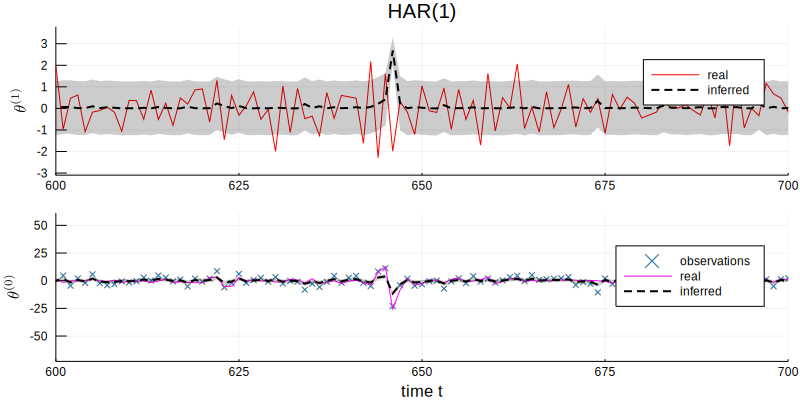

In [18]:
from = 600
upto = 700
scatter(y, markershape = :xcross, markeralpha = 0.6, xlims=(from, upto),
        ylims=(minimum(y[from:upto]) - 50, maximum(y[from:upto]) + 50),
        markersize = 2, xlabel="time t", ylabel=L"\theta^{(0)}", label="observations")
plot!(x, color=:magenta, label="real", title="")
pHAR = plot!(m_xt, ribbon=sqrt.(v_xt),
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")

plot(xlims=(from, upto), ylabel=L"\theta^{(1)}")
plot!(Œ∏, color=:red, label="real", title="Inference 2d layer")
pAR = plot!(m_Œ∏1t, ribbon=sqrt.(v_Œ∏1t),
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred", title="HAR(1)")

plot(pAR, pHAR, layout=(2,1), size=(800, 400))

# AR(1) model
As a benchamrk, we use the following RW model.
\begin{align*}
    &x_t = \theta^{(0)}x_{t-1} + p_t \quad p_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = x_t + m_t \quad m_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

where $\gamma_y^{-1} = 200$

In [19]:
include("../models/ForneyAR.jl")
using .ForneyAR
ARorder = 1

1

In [20]:
gar, qar = ForneyAR.buildGraphAR(ARorder)
#setCurrentGraph(gar)
ForneyLab.draw(gar)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 614900949133029580 -->
 
 614900949133029580 
 
 ùí© 
 gaussianmeanprecision_2 
 
<!-- 11544758156276046378 -->
 
 11544758156276046378 
 
 placeholder_w_x_t_prev 
 
<!-- 614900949133029580--11544758156276046378 -->
 
 614900949133029580--11544758156276046378 
 
 w_x_t_prev 
 1 out 
 3 w 
 
<!-- 903880594915108057 -->
 
 903880594915108057 
 
 placeholder_m_x_t_prev 
 
<!-- 614900949133029580--903880594915108057 -->
 
 614900949133029580--903880594915108057 
 
 m_x_t_prev 
 1 out 
 2 m 
 
<!-- 9620379639439896685 -->
 
 9620379639439896685 
 
 placeholder_a_w_t 
 
<!-- 11257884315780348757 -->
 
 11257884315780348757 
 
 ùí© 
 gaussianmeanprecision_1 
 
<!-- 8013399332627464799 -->
 
 8013399332627464799 
 
 placeholder_w_Œ∏_t 
 
<!-- 11257884315780348757--8013399332627464799 -->
 
 11257884315780348757--8013399332627464799 
 
 w_Œ∏_t 
 1 out 
 3 w 
 
<!-- 8398402168315196987 -->
 
 8398402168315196987 
 
 placeholder_m_Œ∏_t 
 
<!-- 11257884315780348757--8398402168315196987 -->
 
 11257884315780348757--8398402168315196987 
 
 m_Œ∏_t 
 1 out 
 2 m 
 
<!-- 13938879304158318166 -->
 
 13938879304158318166 
 
 ùí© 
 gaussianmeanprecision_3 
 
<!-- 3252041226874553368 -->
 
 3252041226874553368 
 
 dot 
 dotproduct_1 
 
<!-- 13938879304158318166--3252041226874553368 -->
 
 13938879304158318166--3252041226874553368 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 11279196009578820103 -->
 
 11279196009578820103 
 
 placeholder_w_y_t 
 
<!-- 13938879304158318166--11279196009578820103 -->
 
 13938879304158318166--11279196009578820103 
 
 w_y_t 
 1 out 
 3 w 
 
<!-- 8949507761759686675 -->
 
 8949507761759686675 
 
 clamp_1 
 
<!-- 3252041226874553368--8949507761759686675 -->
 
 3252041226874553368--8949507761759686675 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 17069059208327800105 -->
 
 17069059208327800105 
 
 AR 
 autoregression_1 
 
<!-- 3252041226874553368--17069059208327800105 -->
 
 3252041226874553368--17069059208327800105 
 
 x_t 
 1 y 
 2 in1 
 
<!-- 10730476884576437581 -->
 
 10730476884576437581 
 
 placeholder_y_t 
 
<!-- 10730476884576437581--13938879304158318166 -->
 
 10730476884576437581--13938879304158318166 
 
 y_t 
 1 out 
 1 out 
 
<!-- 5099491304595411813 -->
 
 5099491304595411813 
 
 Gam 
 gamma_1 
 
<!-- 5099491304595411813--9620379639439896685 -->
 
 5099491304595411813--9620379639439896685 
 
 a_w_t 
 1 out 
 2 a 
 
<!-- 13842128269826360738 -->
 
 13842128269826360738 
 
 placeholder_b_w_t 
 
<!-- 5099491304595411813--13842128269826360738 -->
 
 5099491304595411813--13842128269826360738 
 
 b_w_t 
 1 out 
 3 b 
 
<!-- 17069059208327800105--614900949133029580 -->
 
 17069059208327800105--614900949133029580 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 17069059208327800105--11257884315780348757 -->
 
 17069059208327800105--11257884315780348757 
 
 Œ∏ 
 1 out 
 3 Œ∏ 
 
<!-- 17069059208327800105--5099491304595411813 -->
 
 17069059208327800105--5099491304595411813 
 
 Œ≥ 
 1 out 
 4 Œ≥

In [41]:
# AR(1)
prs = Dict(:m_Œ∏=>ones(ARorder), :w_Œ∏=>diagAR(ARorder),
           :m_x=>zeros(ARorder), :w_x=>huge*diagAR(ARorder),
           :a=>0.00001, :b=>1.0)

# If Julia throws an error just ignore and re-run this (inference) block again
result = ForneyAR.inferAR(qar, y, v_y, priors=prs, r_stats=true);

LinearAlgebra.LAPACKException: LinearAlgebra.LAPACKException(1)

In [22]:
# Inspect the results
marginals = result[1]
FAR = result[3]
posteriors = result[4]

m_x = posteriors[:m_x]
w_x = posteriors[:w_x]
m_Œ∏ = posteriors[:m_Œ∏]
w_Œ∏ = posteriors[:w_Œ∏]
a = posteriors[:a]
b = posteriors[:b]

m_ar = [x[1] for x in m_x]
v_ar = [v_x[1]^-1 for v_x in w_x[1:end]];

logPDFsAR = [logPDF(x[t], m_ar[t], v_ar[t]) for t in 1:length(y)]
WMSEsAR = [wmse(x[1:t], [est[1] for est in m_x[1:t]], [est[1]^-1 for est in w_x[1:t]]) for t in 1:length(y)];

In [23]:
println("Process noise variance\n=========")
println("Estimated ", mean(marginals[:Œ≥])^-1)
println("True ", 1.0)

println("\nState\n=========")
println("Mean ", mean(marginals[:x_t]))
println("Var ", var(marginals[:x_t]))

Process noise variance
Estimated 5.534382224696331
True 1.0

State
Mean [-0.563801]
Var [3.5628]


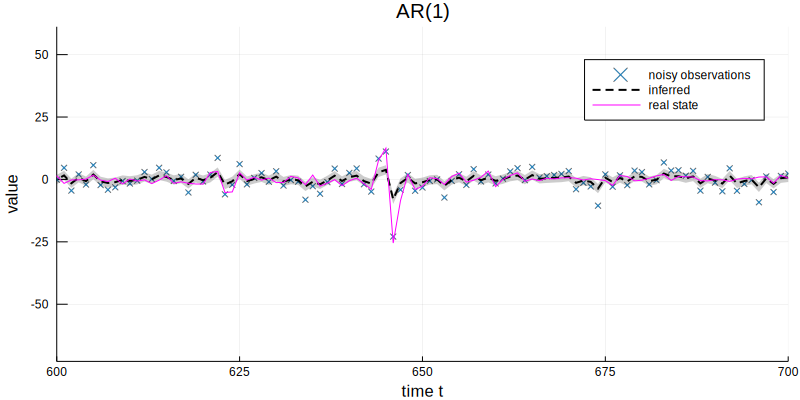

In [24]:
from = 600
upto = 700 # limit for building a graph 
scale = 1.0 # scale for the variance

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!(m_ar, ribbon=sqrt.(v_ar),
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pAR = plot!(xlims=(from, upto),
            ylims=(minimum(y[from:upto]) - 50, maximum(y[from:upto]) + 50),
            size=(800, 400),
            xlabel="time t", ylabel="value", title="AR($ARorder)")

# RW model
As a benchamrk, we use the following RW model.
\begin{align*}
    &x_t = x_{t-1} + p_t \quad p_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = x_t + m_t \quad m_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

where $\gamma_y^{-1} = 200$

In [25]:
using .ForneyAR
ARorder = 1

1

In [26]:
grw, qrw = ForneyAR.buildGraphAR(ARorder)
ForneyLab.draw(grw)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 6127498891014979860 -->
 
 6127498891014979860 
 
 placeholder_w_x_t_prev 
 
<!-- 1667234094309726634 -->
 
 1667234094309726634 
 
 placeholder_b_w_t 
 
<!-- 2843402889490024169 -->
 
 2843402889490024169 
 
 placeholder_y_t 
 
<!-- 2236865501377714465 -->
 
 2236865501377714465 
 
 ùí© 
 gaussianmeanprecision_3 
 
<!-- 2843402889490024169--2236865501377714465 -->
 
 2843402889490024169--2236865501377714465 
 
 y_t 
 1 out 
 1 out 
 
<!-- 5153458334984260997 -->
 
 5153458334984260997 
 
 placeholder_m_Œ∏_t 
 
<!-- 2857740901620222267 -->
 
 2857740901620222267 
 
 dot 
 dotproduct_1 
 
<!-- 4315553401040650335 -->
 
 4315553401040650335 
 
 clamp_1 
 
<!-- 2857740901620222267--4315553401040650335 -->
 
 2857740901620222267--4315553401040650335 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 5160052027154374005 -->
 
 5160052027154374005 
 
 AR 
 autoregression_1 
 
<!-- 2857740901620222267--5160052027154374005 -->
 
 2857740901620222267--5160052027154374005 
 
 x_t 
 1 y 
 2 in1 
 
<!-- 1541435623529935061 -->
 
 1541435623529935061 
 
 ùí© 
 gaussianmeanprecision_1 
 
<!-- 1541435623529935061--5153458334984260997 -->
 
 1541435623529935061--5153458334984260997 
 
 m_Œ∏_t 
 1 out 
 2 m 
 
<!-- 12440634641176977075 -->
 
 12440634641176977075 
 
 placeholder_w_Œ∏_t 
 
<!-- 1541435623529935061--12440634641176977075 -->
 
 1541435623529935061--12440634641176977075 
 
 w_Œ∏_t 
 1 out 
 3 w 
 
<!-- 2236865501377714465--2857740901620222267 -->
 
 2236865501377714465--2857740901620222267 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 14020242122819368436 -->
 
 14020242122819368436 
 
 placeholder_w_y_t 
 
<!-- 2236865501377714465--14020242122819368436 -->
 
 2236865501377714465--14020242122819368436 
 
 w_y_t 
 1 out 
 3 w 
 
<!-- 2308649016013726512 -->
 
 2308649016013726512 
 
 placeholder_m_x_t_prev 
 
<!-- 3207958739179246132 -->
 
 3207958739179246132 
 
 ùí© 
 gaussianmeanprecision_2 
 
<!-- 3207958739179246132--6127498891014979860 -->
 
 3207958739179246132--6127498891014979860 
 
 w_x_t_prev 
 1 out 
 3 w 
 
<!-- 3207958739179246132--2308649016013726512 -->
 
 3207958739179246132--2308649016013726512 
 
 m_x_t_prev 
 1 out 
 2 m 
 
<!-- 7833904029316494049 -->
 
 7833904029316494049 
 
 placeholder_a_w_t 
 
<!-- 5160052027154374005--1541435623529935061 -->
 
 5160052027154374005--1541435623529935061 
 
 Œ∏ 
 1 out 
 3 Œ∏ 
 
<!-- 5160052027154374005--3207958739179246132 -->
 
 5160052027154374005--3207958739179246132 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 3680175449255641345 -->
 
 3680175449255641345 
 
 Gam 
 gamma_1 
 
<!-- 5160052027154374005--3680175449255641345 -->
 
 5160052027154374005--3680175449255641345 
 
 Œ≥ 
 1 out 
 4 Œ≥ 
 
<!-- 3680175449255641345--1667234094309726634 -->
 
 3680175449255641345--1667234094309726634 
 
 b_w_t 
 1 out 
 3 b 
 
<!-- 3680175449255641345--7833904029316494049 -->
 
 3680175449255641345--7833904029316494049 
 
 a_w_t 
 1 out 
 2 a

In [27]:
# RW
prs = Dict(:m_Œ∏=>ones(ARorder), :w_Œ∏=>huge*diagAR(ARorder),
           :m_x=>zeros(ARorder), :w_x=>huge*diagAR(ARorder),
           :a=>0.00001, :b=>1.0)


# If Julia throws an error just ignore and re-run this (inference) block again
result = ForneyAR.inferAR(qrw, y, v_y, priors=prs, r_stats=true);

Observed 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:00:01


In [28]:
# Inspect the results
marginals = result[1]
FRW = result[3]
posteriors = result[4]

m_x = posteriors[:m_x]
w_x = posteriors[:w_x]
m_a = posteriors[:m_Œ∏]
w_a = posteriors[:w_Œ∏]
a = posteriors[:a]
b = posteriors[:b]

m_rw = [x[1] for x in m_x]
v_rw = [v_x[1]^-1 for v_x in w_x[1:end]];

logPDFsRW = [logPDF(x[t], m_rw[t], v_rw[t]) for t in 1:length(y)]
WMSEsRW = [wmse(x[1:t], [est[1] for est in m_x[1:t]], [est[1]^-1 for est in w_x[1:t]]) for t in 1:length(y)];

In [29]:
println("Process noise variance\n=========")
println("Estimated ", mean(marginals[:Œ≥])^-1)
println("True ", 1.0)

println("\nState\n=========")
println("Mean ", mean(marginals[:x_t]))
println("Var ", var(marginals[:x_t]))

Process noise variance
Estimated 1.999960299648956e8
True 1.0

State
Mean [-1.58247]
Var [10.0]


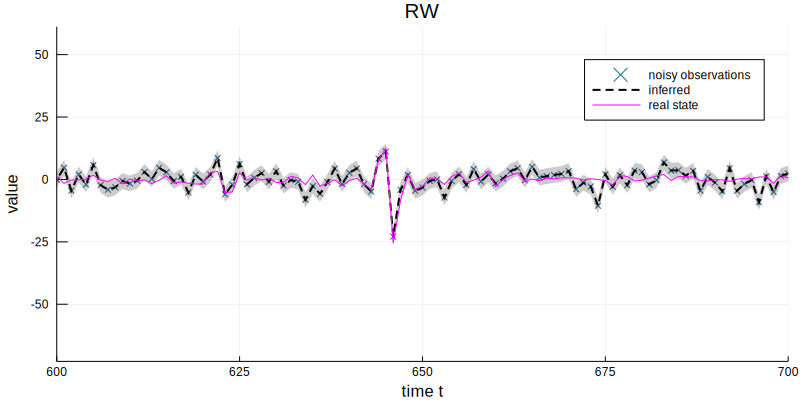

In [30]:
from = 600
upto = 700 # limit for building a graph 
scale = 1.0 # scale for the variance

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!(m_rw, ribbon=sqrt.(v_rw),
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pRW = plot!(xlims=(from, upto),
            ylims=(minimum(y[from:upto]) - 50, maximum(y[from:upto]) + 50),
            size=(800, 400),
            xlabel="time t", ylabel="value", title="RW")

# Comparison (RW vs HAR)
To assess the performance of our model, we use the following metrics:
Free Energy:
$$F_t[q]\triangleq \int q(\mathbf{x}_t)\log\frac{q(\mathbf{x}_t)}{p(\mathbf{x}_t, y_t\big|\mathbf{y}_{1:t-1})}d\mathbf{x}_t$$

log PDF, i.e.:
$$-\frac{1}{2}\log{2\pi v_x}-\frac{(m_{x_{k}}-x_{k})^2}{2v_x}$$

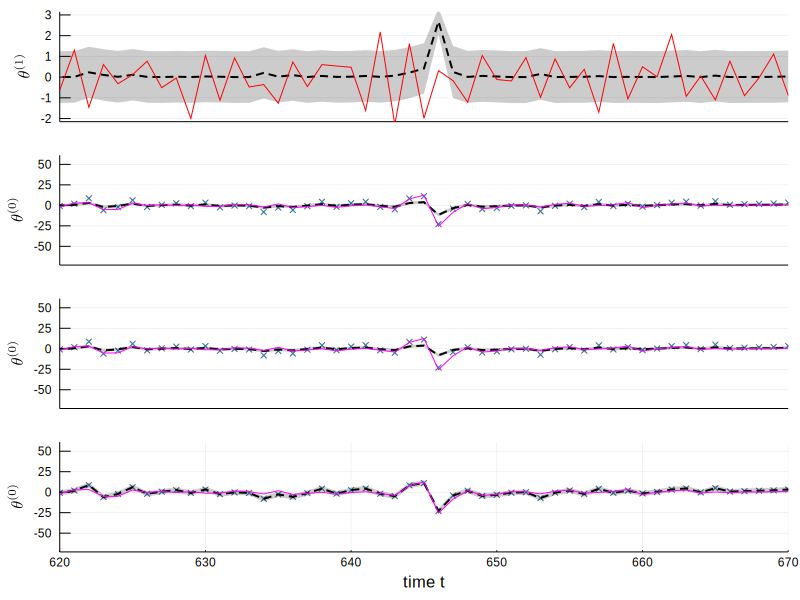

In [32]:
from = 620
upto = 670 # limit for building a graph 
scale = 1.0 # scale for the variance

plot(m_Œ∏1t, ribbon=sqrt.(v_Œ∏1t),
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(Œ∏[2:end], color=:red, label="real", title="")
pHAR1 = plot!(ylabel=L"\theta^{(1)}", title="", legend=false, xticks=[], ylims=[-2, 3])

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!(m_xt, ribbon=sqrt.(v_xt),
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")
plot!(x, color = :magenta, linewidth = 1.0, label="real state",  ylabel=L"\theta^{(0)}")
pHAR = plot!(title="", legend=false, ylims=(minimum(y[from:upto]) - 50, maximum(y[from:upto]) + 50), xticks=[])

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!(m_ar, ribbon=sqrt.(v_ar),
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pAR = plot!(ylabel=L"\theta^{(0)}", ylims=(minimum(y[from:upto]) - 50, maximum(y[from:upto]) + 50), xticks=[])

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!(m_rw, ribbon=sqrt.(v_rw),
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pRW = plot!(xlabel="time t",  ylabel=L"\theta^{(0)}", ylims=(minimum(y[from:upto]) - 50, maximum(y[from:upto]) + 50))

plot(pHAR1, pHAR, pAR, pRW, xlims=(from, upto), 
    layout=(4,1),  size=(800, 600), legend=false)

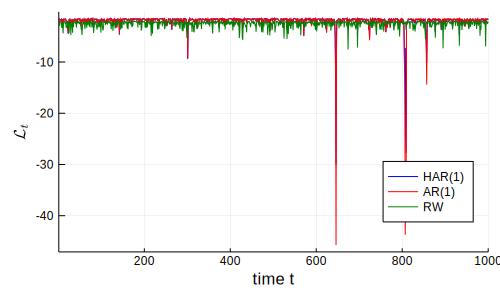

In [33]:
# log PDFs
from = 1; upto = 1000
plot(logPDFsHAR[1:end], color=:blue, label="HAR($HARorder)")
plot!(logPDFsAR[1:end], color=:red, label="AR($ARorder)", xlabel="time t", ylabel=L"\mathcal{L}_t", size=(500, 300), legend=:bottomright)
plt = plot!(logPDFsRW[1:end], color=:green, label="RW", xlims=(from, upto))
#savefig("logPDF.png")

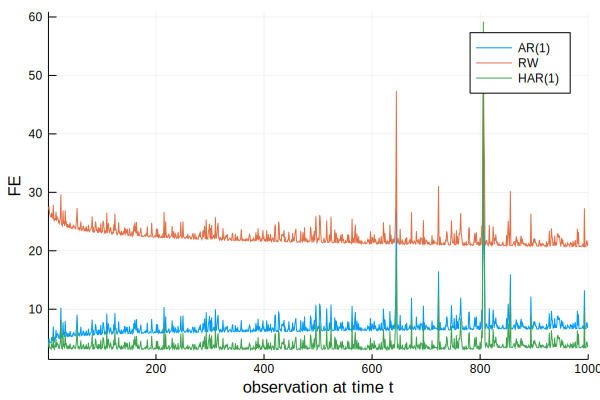

In [34]:
# Free energy
from, upto = 1, 1000
plot(FAR[2:end], label="AR($ARorder)", xlims=(from, upto))
plot!(FRW[2:end], label="RW", xlims=(from, upto))
plot!(FHAR[2:end], label="HAR($HARorder)", xlabel="observation at time t", ylabel="FE")

In [35]:
sum(logPDFsAR)

-2105.6486644553584

In [36]:
sum(logPDFsRW)

-2546.7452752001964

In [37]:
sum(logPDFsHAR)

-2023.1077895280744

In [38]:
sum(FAR)

6939.216943219337

In [39]:
sum(FRW)

22451.898453087106

In [40]:
sum(FHAR)

3931.634341006019

# Animation

In [34]:
v_x = v_xt # variances of estimated state
m_ar = m_xt
toshow = 20 # number of points to plot at once

anim = @animate for i in 300:length(m_ar)-toshow
    s = plot(xticks = i:div(toshow, 2):i+toshow, size=(800, 300));
    ylims!(minimum(y) - .1, maximum(y) + .1);
    scatter!(collect(i:i+toshow), y[i:i+toshow], label="observations", 
            markershape = :xcross, markeralpha = 0.6,
            markersize = 2)
    
    plot!(collect(i:i+toshow), m_ar[i:i+toshow], ribbon=sqrt.(v_x[i:i+toshow]),
          linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black,
          label="inferred", title = "1st layer")
    
    plot!(collect(i:i+toshow), x[i:i+toshow], color = :magenta, linewidth = 1.0, label="real", xlabel="time t", ylabel=L"\theta^{(0)}")
end

Animation("/var/folders/jn/1xv7kskx42v_97gx1xd8y_g40000gq/T/tmpoDmYHe", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  ‚Ä¶  "000672.png", "000673.png", "000674.png", "000675.png", "000676.png", "000677.png", "000678.png", "000679.png", "000680.png", "000681.png"])

In [35]:
gif(anim, "../gifs/1stHAR.gif", fps = 10)

‚îå Info: Saved animation to 
‚îÇ   fn = /Users/albertpod/Documents/Julia/VMP-AR/gifs/1stHAR.gif
‚îî @ Plots /Users/albertpod/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VMP-AR/gifs/1stHAR.gif")

In [36]:
v_x = v_Œ∏1t # variances of estimated state
m_ar = m_Œ∏1t
toshow = 20 # number of points to plot at once

anim = @animate for i in 300:length(m_ar)-toshow
    s = plot(xticks = i:div(toshow, 2):i+toshow, size=(800, 300));
    ylims!(-10, 10);
    
    plot!(collect(i:i+toshow), m_ar[i:i+toshow], ribbon=sqrt.(v_x[i:i+toshow]),
          linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black,
          label="inferred", title = "2d layer")
    
    plot!(collect(i:i+toshow), Œ∏[i:i+toshow], color = :red, linewidth = 1.0, label="real", ylabel=L"\theta^{(1)}")
end

Animation("/var/folders/jn/1xv7kskx42v_97gx1xd8y_g40000gq/T/tmpGoefsx", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  ‚Ä¶  "000672.png", "000673.png", "000674.png", "000675.png", "000676.png", "000677.png", "000678.png", "000679.png", "000680.png", "000681.png"])

In [37]:
gif(anim, "../gifs/2stHAR.gif", fps = 10)

‚îå Info: Saved animation to 
‚îÇ   fn = /Users/albertpod/Documents/Julia/VMP-AR/gifs/2stHAR.gif
‚îî @ Plots /Users/albertpod/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VMP-AR/gifs/2stHAR.gif")

In [38]:
# Plotting MSE
anim = @animate for i in 1:length(logPDFsRW)
    s = plot(size=(800, 300))
    ylims!(-20, 0)
    xlims!(1, length(logPDFsRW))
    plot!(collect(1:i), logPDFsHAR[1:i], xlabel="time t", ylabel=L"\mathcal{L}_t", color=:blue, label="HAR($HARorder)")
    plot!(collect(1:i), logPDFsAR[1:i], color=:red, label="AR($HARorder)")
    plot!(collect(1:i), logPDFsRW[1:i], color=:green, label="RW")
end;

In [39]:
gif(anim, "../gifs/logPDFevo.gif", fps = 10)

‚îå Info: Saved animation to 
‚îÇ   fn = /Users/albertpod/Documents/Julia/VMP-AR/gifs/logPDFevo.gif
‚îî @ Plots /Users/albertpod/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VMP-AR/gifs/logPDFevo.gif")